In [1]:
import numpy as np
import pandas as pd
import scipy
import imageio
import math
import phylo as ph

from PIL import Image

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns
import warnings
sns.set(style="ticks")
plt.style.use("seaborn-whitegrid")

In [2]:
%load_ext blackcellmagic

# Preparation

All the expensive setup happens up here.

In [3]:
np.random.seed(820)
REGULAR_POKEMON = ph.vectorize_pokemon(ph.REGULAR_POKEMON_PATH)
SHINY_POKEMON = ph.vectorize_pokemon(ph.SHINY_POKEMON_PATH)

Vectorizing pokemon from /Users/vineshkannan/Documents/GitHub/phylo/images/regular/
Vector iteration 0
Vector iteration 100
Vector iteration 200
Vector iteration 300
Vector iteration 400
Vector iteration 500
Vector iteration 600
Done vectorizing
Vectorizing pokemon from /Users/vineshkannan/Documents/GitHub/phylo/images/shiny/
Vector iteration 0
Vector iteration 100
Vector iteration 200
Vector iteration 300
Vector iteration 400
Vector iteration 500
Vector iteration 600
Done vectorizing


In [4]:
known_creatures = list(REGULAR_POKEMON) + list(SHINY_POKEMON)
np.random.shuffle(known_creatures)

In [5]:
random_vectors = [ph.generate_random() for i in range(len(known_creatures))]
expect_base_pop = known_creatures + random_vectors
len(expect_base_pop)

2596

In [6]:
n_expected = 200
expected_from_n_sub = 50
expected_vectors = []
for i in range(n_expected):
    ev = ph.generate_expected(expect_base_pop, expected_from_n_sub)
    ev_ob = ph.outline_body(ev)
    expected_vectors.append(ev_ob)
    if i % 10 == 0:
        print(i)
print("Done.")

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
Done.


# Genetic Algorithm

## Pseudocode

- Select initial population
- While offspring have not converged
    - Score population on fitness function
    - Eliminate least fit members
    - Select parents to mate and perform 2D crossovers
    - Apply mutations to maintain diversity
        - Random mutations to members?
        - Introduce new members from the set of known creatures?
    - Update population
    - Measure change in overall fitness

In [67]:
WEIGHT = [-5.37720197,  2.15129582, -2.7828926 , 12.3475064 , -1.90558047]

def choose_from(options, n):
    idxs = np.random.choice(range(len(options)), n)
    return [options[i] for i in idxs]

def fitness(xv):
    qv = ph.col_freq(xv)
    s = np.dot(WEIGHT, qv).sum()
    return np.exp(s) / (1.0 + np.exp(s))
    #return 0.0

def crossover(p1, p2, x, y, r):
    m1 = np.array(p1).reshape(ph.M, ph.M)
    m2 = np.array(p2).reshape(ph.M, ph.M)
    for yi in range(y - r, y + r + 1):
        for xi in range(x - r, x + r + 1):
            if ph.in_im(xi, yi):
                keep = np.uint8(m1[yi][xi])
                m1[yi][xi] = m2[yi][xi]
                m2[yi][xi] = keep
    c1 = m1.reshape(ph.M**2)
    c2 = m2.reshape(ph.M**2)
    return c1, c2

def mutate_form(cx, px):
    subsample = np.array([cx, cx, px, px] + [ph.generate_random() for i in range(2)])
    ev = ph.expect_from_subsample(subsample)
    bv = ph.outline_body(ev)
    return bv

In [85]:
population = choose_from(known_creatures, 100) + choose_from(expected_vectors, 100)

In [86]:
pop_half = math.floor(len(population) / 2)
pop_quart = math.floor(pop_half / 2)
xc = math.floor(ph.M / 2)
yc = math.floor(ph.M / 2)
radius = 10
t = 0
max_turns = 10
scores = []
while True:
    members = pd.DataFrame()
    members["i"] = range(len(population))
    members["fitness"] = members["i"].apply(lambda i: fitness(population[i]))
    helicopters = members.sort_values(by="fitness", ascending=False).reset_index(drop=True)
    if t >= max_turns:
        break
    new_pop = []
    if False:
        for m in range(pop_quart):
            p1_idx = helicopters["i"][m]
            p2_idx = helicopters["i"][(pop_quart - m) - 1]
            p1 = population[p1_idx]
            p2 = population[p2_idx]
            c1, c2 = crossover(p1, p2, xc, yc, radius)
            new_pop.append(p1)
            new_pop.append(p2)
            new_pop.append(c1)
            new_pop.append(c2)
    for m in range(pop_quart):
        mate_idxs = np.random.choice(range(len(population)), 2)
        p1 = population[mate_idxs[0]]
        p2 = population[mate_idxs[1]]
        print("Mate: {} and {}".format(*mate_idxs))
        c1, c2 = crossover(p1, p2, xc, yc, radius)
        new_pop.append(p1)
        new_pop.append(p2)
        new_pop.append(c1)
        new_pop.append(c2)
    if False:
        num_mutate = 2 # np.random.randint(pop_quart)
        mutate_idxs = np.random.choice(len(new_pop), num_mutate)
        for midx in mutate_idxs:
            pxv = None
            cxv = None
            if midx % 2 == 0: # selected parent index
                pxv = new_pop[midx]
                cxv = new_pop[midx + 1]
            else: # selected child index
                pxv = new_pop[midx - 1]
                cxv = new_pop[midx]
            new_pop[midx] = mutate_form(cxv, pxv)
    if False:
        replacements = 3
        entrants = choose_from(known_creatures, replacements)
        for i in range(replacements):
            if helicopters["fitness"][i] < 0:
                print("Current: {0:3f}".format(fitness(new_pop[(4 * i)])))
                print("Entrant: {0:3f}".format(fitness(entrants[i])))
                new_pop[(4 * i)] = entrants[i]
    population = new_pop
    scores.append(helicopters["fitness"][0])
    t += 1
    print("Completed Turn {}".format(t))
print("Done.")

Mate: 1 and 132
Mate: 110 and 50
Mate: 83 and 56
Mate: 52 and 94
Mate: 18 and 109
Mate: 17 and 119
Mate: 81 and 112
Mate: 102 and 154
Mate: 172 and 53
Mate: 141 and 124
Mate: 170 and 50
Mate: 142 and 78
Mate: 99 and 23
Mate: 177 and 143
Mate: 105 and 185
Mate: 78 and 45
Mate: 115 and 174
Mate: 38 and 15
Mate: 62 and 126
Mate: 2 and 117
Mate: 179 and 20
Mate: 114 and 96
Mate: 187 and 185
Mate: 25 and 64
Mate: 1 and 119
Mate: 20 and 189
Mate: 16 and 152
Mate: 142 and 133
Mate: 65 and 113
Mate: 106 and 1
Mate: 125 and 86
Mate: 47 and 23
Mate: 67 and 186
Mate: 66 and 104
Mate: 174 and 8
Mate: 113 and 123
Mate: 176 and 135
Mate: 147 and 79
Mate: 191 and 105
Mate: 95 and 100
Mate: 19 and 51
Mate: 20 and 100
Mate: 39 and 169
Mate: 32 and 7
Mate: 191 and 117
Mate: 82 and 57
Mate: 105 and 36
Mate: 57 and 26
Mate: 188 and 172
Mate: 150 and 43
Completed Turn 1
Mate: 170 and 70
Mate: 89 and 49
Mate: 188 and 170
Mate: 94 and 31
Mate: 163 and 95
Mate: 24 and 64
Mate: 36 and 75
Mate: 131 and 71
Mate:

In [87]:
helicopters.head(10)

,i,fitness
0,199,0.062032
1,60,0.046359
2,147,0.043579
3,46,0.043400
4,62,0.040438
5,73,0.040382
6,197,0.040382
7,170,0.040286
8,75,0.039773
9,145,0.039656


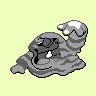

In [88]:
ph.showim(population[199])

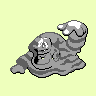

In [90]:
ph.showim(population[60])

In [91]:
for j in range(10):
    pidx = helicopters["i"][j]
    ph.showim(population[pidx]).show()